In [27]:
module OcclusionFreeMclWorld

using Plots
using Distributions
using StatsBase
using LinearAlgebra
using Printf
using Logging
Logging.disable_logging(Logging.Info)

include("../scripts/mcl.jl")
import .MclWorld: RealRobot, RealCamera
import .MclWorld: IdealAgent, Agent, EstimationAgent, Landmark, Map, Camera, Robot, World
import .MclWorld: data, decision, state_transition, circle_shape, draw, append
import .MclWorld: Mcl, Estimator, Particle, set_ml, motion_update, observation_update, observation_function, resampling_system

function observation_update(self::Particle, observation, map, distance_dev_rate, direction_dev)
    for (key, value) in observation
        
        obs_pos = value
        obs_id = key

        pos_on_map = map.landmarks[obs_id].pos        
        particle_suggest_pos=observation_function(self.pose, pos_on_map)

        distance_dev = distance_dev_rate*particle_suggest_pos[1]
        cov = diagm([distance_dev^2, direction_dev^2]) #ここまでParticleFilterと同じ実装
        if obs_pos[1] > particle_suggest_pos[1] #観測された距離がパーティクルから計算される距離より大きい場合
           obs_pos[1] = particle_suggest_pos[1] #パーティクルから計算される距離で観測された距離を置き換える
        end
        self.weight = self.weight * pdf(MvNormal(particle_suggest_pos, cov), obs_pos)
    end
end

end

Main.OcclusionFreeMclWorld

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_advanced_localization/tmp.gif")
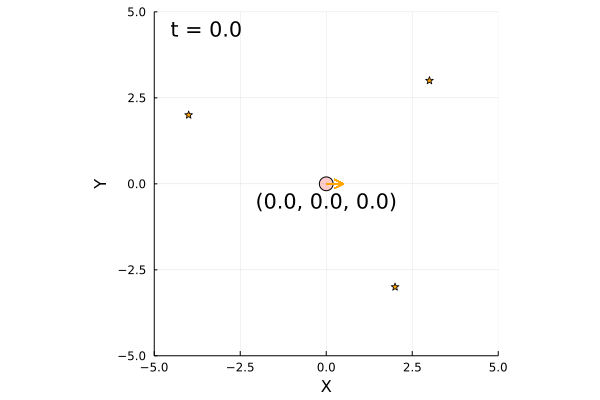

In [28]:
using .OcclusionFreeMclWorld

time_interval = 0.1    
world = OcclusionFreeMclWorld.World(30, 0.1)

### 地図を生成して３つランドマークを追加 ###
m = OcclusionFreeMclWorld.Map()
OcclusionFreeMclWorld.append(m, OcclusionFreeMclWorld.Landmark([-4, 2]))
OcclusionFreeMclWorld.append(m, OcclusionFreeMclWorld.Landmark([2, -3]))
OcclusionFreeMclWorld.append(m, OcclusionFreeMclWorld.Landmark([3, 3]))
OcclusionFreeMclWorld.append(world, m)

initial_pose = [0, 0, 0]
pf = OcclusionFreeMclWorld.Mcl(initial_pose, 100, map=m)
circling = OcclusionFreeMclWorld.EstimationAgent(time_interval, 0.2, 10.0/180.0*pi, pf)
r = OcclusionFreeMclWorld.RealRobot(initial_pose, :red, 0.2, circling, sensor=OcclusionFreeMclWorld.RealCamera(m, occlusion_prob=0.5))
OcclusionFreeMclWorld.append(world, r)

OcclusionFreeMclWorld.draw(world)